# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [1]:
# Import packages
import os
import re # in radiance.py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np # in radiance.py
import pandas as pd # in radiance.py
from pandas.io.json import json_normalize # in radiance.py
import rasterio as rio # in radiance.py
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em # in radiance.py
import radiance as rd

### Set Package Options

In [2]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define Functions

Defined in `radiance.py`

### Set Working Directory

In [3]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "penn-state-radiance")

## Data Preparation

### Define File Paths

In [4]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "radiance_files")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF.csv")

In [5]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Radiance_RavelOrderF.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_CloudMask_RavelOrderF.csv


### Read CSV Files to Geodataframes

In [6]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [7]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [8]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [9]:
psu_radiance_df.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-22,2019-09-23,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-10-01,2019-10-02,2019-10-04,2019-10-05,2019-10-06,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-30,2019-11-01,2019-11-02,2019-11-03,2019-11-05,2019-11-06,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-27,2019-11-28,2019-11-29,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-25,2020-04-26,2020-04-27,2020-04-28
0,12,6,9,7,14,7,7,16,10,35,103,194,34,38,22,22,24,11,88,6,10,9,11,7,10,8,6,15,9,47,11,22,33,37,86,41,110,73,20,57,25,16,14,8,146,24,7,9,10,12,10,10,19,7,14,19,46,148,116,34,98,29,52,24,13,11,13,3,7,21,16,19,16,33,17,5,14,27,18,33,86,92,176,132,116,185,155,70,68,21,18,17,8,25,6,11,12,11,25,9,8,14,10,9,12,11,17,45,88,116,157,254,225,57,70,18,30,36,24,20,22,17,23,53,9,25,7,13,8,11,14,7,11,4,35,67,61,227,353,294,152,43,82,41,10,30,12,7,10,10,12,12,6,6,16,13,17,16,15,8,10,13,13,15,18,122,38,95,189,33,47,65,17,23,11,6,11,6,3,10,9,6,7,1,6,5,10,6,24,7,9,6,4,14
1,11,6,9,7,14,15,11,16,18,44,103,194,34,45,22,32,24,13,88,27,18,9,11,9,10,18,25,15,9,47,24,22,37,39,86,41,113,73,20,61,25,16,22,13,146,28,7,15,12,12,20,29,20,16,20,18,51,151,116,102,104,44,52,24,22,11,13,3,12,21,22,19,16,33,27,4,17,27,18,41,100,95,190,132,123,175,155,70,71,28,19,17,7,25,8,17,17,11,25,9,9,20,81,9,10,19,17,47,88,119,157,242,233,57,76,26,35,50,25,31,43,17,29,56,10,23,9,20,16,11,21,7,11,59,35,62,62,227,353,293,159,44,83,40,10,34,12,7,10,15,12,12,17,9,18,14,17,16,26,54,20,16,13,29,30,124,41,95,189,45,50,66,18,24,11,8,12,6,3,10,22,7,7,1,13,5,10,7,24,10,14,4,7,17
2,11,6,17,18,35,60,11,15,18,41,105,197,50,98,42,32,31,14,31,27,44,18,85,7,18,16,25,17,15,24,24,48,51,133,86,36,109,73,20,61,35,14,19,23,16,28,7,15,12,19,20,31,20,46,20,18,75,153,118,102,104,44,58,31,18,19,29,3,16,27,29,30,17,35,41,4,17,34,25,41,100,96,189,133,133,175,147,74,69,32,29,19,7,15,31,17,17,14,36,5,11,21,81,9,10,19,19,47,98,162,158,242,239,89,76,26,35,50,25,89,43,81,29,56,10,25,9,20,16,40,21,7,14,27,42,62,62,243,359,293,160,48,83,43,18,34,12,7,31,19,25,38,17,9,18,14,19,26,26,54,36,16,16,154,92,132,44,96,193,45,61,66,91,25,23,9,12,4,6,12,22,9,18,2,20,7,9,7,40,11,15,4,7,17
3,11,7,66,95,35,60,116,15,135,54,105,202,168,98,106,108,62,97,92,116,44,166,181,17,59,15,57,17,15,24,50,29,44,133,86,36,109,73,176,66,72,14

In [10]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [11]:
psu_cloud_mask_df.head()

,9/1/2019,9/2/2019,9/3/2019,9/4/2019,9/5/2019,9/6/2019,9/7/2019,9/8/2019,9/11/2019,9/12/2019,9/13/2019,9/14/2019,9/15/2019,9/17/2019,9/18/2019,9/19/2019,9/20/2019,9/22/2019,9/23/2019,9/25/2019,9/26/2019,9/27/2019,9/28/2019,10/1/2019,10/2/2019,10/4/2019,10/5/2019,10/6/2019,10/8/2019,10/9/2019,10/10/2019,10/11/2019,10/12/2019,10/13/2019,10/14/2019,10/15/2019,10/17/2019,10/18/2019,10/19/2019,10/20/2019,10/21/2019,10/22/2019,10/23/2019,10/24/2019,10/25/2019,10/26/2019,10/27/2019,10/28/2019,10/30/2019,11/1/2019,11/2/2019,11/3/2019,11/5/2019,11/6/2019,11/8/2019,11/9/2019,11/10/2019,11/11/2019,11/14/2019,11/15/2019,11/16/2019,11/17/2019,11/18/2019,11/19/2019,11/21/2019,11/22/2019,11/23/2019,11/24/2019,11/25/2019,11/27/2019,11/28/2019,11/29/2019,12/1/2019,12/2/2019,12/3/2019,12/4/2019,12/5/2019,12/6/2019,12/7/2019,12/8/2019,12/9/2019,12/10/2019,12/11/2019,12/12/2019,12/13/2019,12/14/2019,12/15/2019,12/16/2019,12/17/2019,12/20/2019,12/21/2019,12/22/2019,12/23/2019,12/24/2019,12/25/2019,12/26/2019,12/27/2019,12/28/2019,12/29/2019,12/30/2019,12/31/2019,1/1/2020,1/2/2020,1/3/2020,1/4/2020,1/5/2020,1/6/2020,1/7/2020,1/8/2020,1/9/2020,1/10/2020,1/11/2020,1/12/2020,1/13/2020,1/14/2020,1/15/2020,1/16/2020,1/17/2020,1/18/2020,1/19/2020,1/20/2020,1/21/2020,1/22/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020
0,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,1,100,100,100,100,100,100,1,100,100,1,100,100,100,1,100,100,100,100,100,1,100,100,100,100,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,1,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
1,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,100,100,100,100,100,100,100,1,100,1,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,100,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
2,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,1,100,100,100,100,1,100,1,100,100,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,1,1,1,100,100,1,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
3,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,

### Add Missings Dates and Data

Keep it indexed by pixel in order to easily call time series for one pixel. Also add Lat/Lon to it in case there is a need to call based on Lat/Long or to plot with data.

Get a plot with the pixel id in order to more easily call specific pixels or groups of pixels.

Data converted from type *int* to type *float* by within the add missing data function.

In [12]:
# Get filled radiance data (dates specified by user)
psu_radiance_filled = rd.add_missing_data(
    psu_radiance_df, '2019-09-01', '2020-04-30')

In [13]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,12.0,6.0,9.0,7.0,14.0,7.0,7.0,16.0,NaN,NaN,10.0,35.0,103.0,194.0,34.0,NaN,38.0,22.0,22.0,24.0,NaN,11.0,88.0,NaN,6.0,10.0,9.0,11.0,NaN,NaN,7.0,10.0,NaN,8.0,6.0,15.0,NaN,9.0,47.0,11.0,22.0,33.0,37.0,86.0,41.0,NaN,110.0,73.0,20.0,57.0,25.0,16.0,14.0,8.0,146.0,24.0,7.0,9.0,NaN,10.0,NaN,12.0,10.0,10.0,NaN,19.0,7.0,NaN,14.0,19.0,46.0,148.0,NaN,NaN,116.0,34.0,98.0,29.0,52.0,24.0,NaN,13.0,11.0,13.0,3.0,7.0,NaN,21.0,16.0,19.0,NaN,16.0,33.0,17.0,5.0,14.0,27.0,18.0,33.0,86.0,92.0,176.0,132.0,116.0,185.0,155.0,70.0,68.0,NaN,NaN,21.0,18.0,17.0,8.0,25.0,6.0,11.0,12.0,11.0,25.0,9.0,8.0,14.0,10.0,9.0,12.0,11.0,17.0,45.0,88.0,116.0,157.0,254.0,225.0,57.0,70.0,18.0,30.0,36.0,24.0,20.0,22.0,17.0,23.0,NaN,53.0,9.0,25.0,7.0,13.0,8.0,11.0,14.0,7.0,11.0,4.0,35.0,67.0,61.0,NaN,227.0,353.0,294.0,152.0,43.0,82.0,41.0,10.0,30.0,12.0,7.0,10.0,10.0,12.0,12.0,6.0,6.0,16.0,13.0,17.0,16.0,15.0,8.0,10.0,13.0,13.0,15.0,18.0,122.0,38.0,95.0,189.0,33.0,47.0,65.0,17.0,23.0,11.0,6.0,11.0,6.0,3.0,10.0,9.0,6.0,7.0,1.0,6.0,5.0,10.0,6.0,24.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,6.0,4.0,14.0,NaN,NaN
1,11.0,6.0,9.0,7.0,14.0,15.0,11.0,16.0,NaN,NaN,18.0,44.0,103.0,194.0,34.0,NaN,45.0,22.0,32.0,24.0,NaN,13.0,88.0,NaN,27.0,18.0,9.0,11.0,NaN,NaN,9.0,10.0,NaN,18.0,25.0,15.0,NaN,9.0,47.0

In [14]:
# Get filled cloud mask data
psu_cloud_mask_filled = rd.add_missing_data(
    psu_cloud_mask_df, '2019-09-01', '2020-04-30')

In [15]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,100.0,100.0,100.0,1.0,NaN,100.0,1.0,1.0,100.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,100.0,1.0,NaN,1.0,1.0,100.0,NaN,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,NaN,100.0,100.0,1.0,100.0,100.0,100.0,1.0,1.0,1.0,100.0,100.0,1.0,NaN,100.0,NaN,100.0,1.0,1.0,NaN,100.0,1.0,NaN,1.0,1.0,100.0,100.0,NaN,NaN,100.0,1.0,100.0,1.0,100.0,100.0,NaN,1.0,100.0,1.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,NaN,NaN,100.0,100.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,100.0,1.0,100.0,1.0,1.0,100.0,1.0,100.0,1.0,100.0,1.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN
1,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,100.0,100.0,100.0,1.0,NaN,100.0,1.0,1.0,100.0,NaN,1.0,1.0,

Is there a way to mask the full dataframe, instead of calling individual months days first? This way, the pre-processing is up front?

Implement something similar to monthly, where user enters date range (radiance and mask data), and the function masks data and stores the masked array in a dictionary?

In [16]:
# Get radiance data for one pixel (Sept 2019 - April 2020)
pixel_id_0_radiance = psu_radiance_filled.loc[0]

In [17]:
# Get cloud mask data for one pixel (Sept 2019 - April 2020)
pixel_id_0_mask = psu_cloud_mask_filled.loc[[0]]

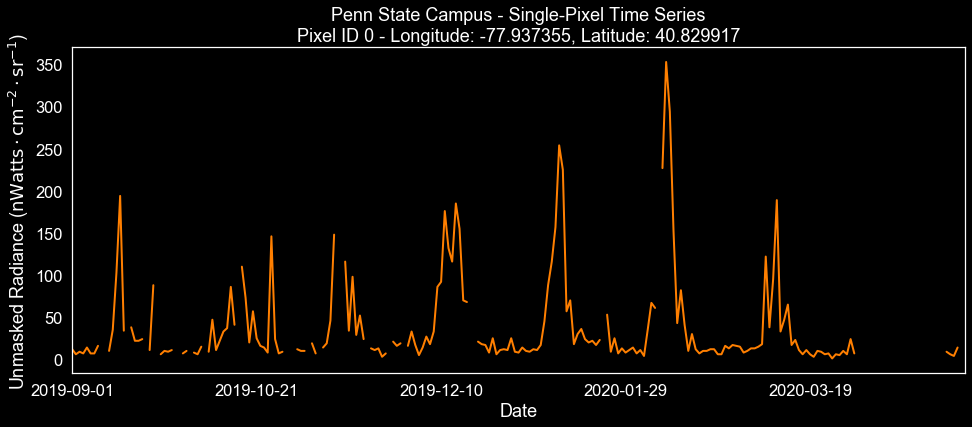

In [18]:
# Plot single-pixel time series
with plt.style.context('dark_background'):
    
    ax = pixel_id_0_radiance.plot(figsize=(16,6), grid=False, color='#ff7f00', linewidth=2)
    
    ax.set_title('Penn State Campus - Single-Pixel Time Series\nPixel ID 0 - Longitude: -77.937355, Latitude: 40.829917')
    ax.set_xlabel('Date')
    ax.set_ylabel('Unmasked Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)')

In [19]:
# # Note - Change date format (both now YYYY-MM-DD)
# #  makes the get cloud_mask_data() function not needed;
# #  both can use the get_radiance_data() function

# # Get Sept 2019 radiance value dataframes into list - FILLED
# sept_2019_radiance_filled = get_radiance_data(
#     psu_radiance_filled, year='2019', month='09')

# # Get Sept 2019 cloud mask dataframes into list - FILLED
# sept_2019_mask_filled = get_radiance_data(
#     psu_cloud_mask_filled, year='2019', month='09')

In [20]:
# sept_2019_radiance_filled[0].head()

In [21]:
# sept_2019_mask_filled[0].head()

In [22]:
# # Calculate mean radiance with filled data
# sept_2019_mean_radiance_filled = calculate_mean_radiance(
#     sept_2019_radiance_filled, sept_2019_mask_filled)

In [23]:
# # Confirm mean radiance (should be 611.1739)
# sept_2019_mean_radiance_filled.max()

### Create Plotting Extent

In [24]:
# Get min/max longitude and latitude values
lon_min = psu_lat_lon_df.Longitude.min()
lon_max = psu_lat_lon_df.Longitude.max()
lat_min = psu_lat_lon_df.Latitude.min()
lat_max = psu_lat_lon_df.Latitude.max()

In [25]:
# Display values
print(f"Lon min: {lon_min}\nLon max: {lon_max}\nLat min: {lat_min}\nLat max: {lat_max}")

Lon min: -77.93735504
Lon max: -77.77485504
Lat min: 40.75908399
Lat max: 40.82991733


In [26]:
# Get spacing for extent (assume lat/lon are centroids)
lon_spacing = (lon_max - lon_min) / 39
lat_spacing = (lat_max - lat_min) / 17

# Check to which decimal the lat and long spacings match
round(lon_spacing, 9) == round(lon_spacing, 9)

# Define single spacing
coord_spacing = round(lon_spacing, 9)

In [27]:
# Define extent
psu_extent = (
    lon_min - coord_spacing/2,
    lon_max + coord_spacing/2,
    lat_min - coord_spacing/2,
    lat_max + coord_spacing/2
)

In [28]:
# # Define extent
# psu_extent = (lon_min-0.004166999999995369/2, 
#               lon_max+0.004166999999995369/2, 
#               lat_min-0.004166999999995369/2, 
#               lat_max+0.004166999999995369/2)

In [29]:
# Show extent (xmin, xmax, ymin, ymax)
psu_extent

(-77.9394383735, -77.77277170650001, 40.7570006565, 40.832000663500004)

In [30]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [31]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

Workflow for storing data in dictionary:

* Define list of dates that for data that will be added to the dictionary
    * ```python
    date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
    ```

* Store data in dictionary
    * ```python
    store_daily_radiance(
        filled_radiance_data, 
        filled_cloud_mask_data, 
        date_list)
    ```
    * For each date in the date list:
        * Finds the date in the dataframe based on column name
        * Creates a correctly formatted (shaped) array for that data (values and cloud mask)
        * Masks if cloud mask values are present
        * Adds year/month/day index to dictionary as key and masked array as value


Workflow for accessing/extracting data from dictionary:

    * Call individual day via dictionary index
        * dictionary[YYYY][MM][DD] (returns array)
        * 
        
    * Call one month of data
        * dictionary[YYYY][MM][DD] (returns dictionary of arrays, with days as keys.
        * To get a list, use flatten_month() function
        
    * Call intra or inter-month data
        * get_date_list()
        * get_array_data_from_dict()
        * calculate_mean_radiance()


    * Define list of dates that for data that will be added to the dictionary
    * ```python
        date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
 ```

Crate function for plotting?

* Get a d


Get daily data into a dictionary, for retrieval several different aggregation levels:

* Daily
* Monthly 
* Ranges of dates (in-between months)

Where data is centrally stored and many functions can act upon that data to run calculations.

1. Read data to dataframes

2. Add missing values

3. Create date list for looping through to pull radiance data (values and cloud mask)
    * *get_date_list()*
    

4. Store daily data in dictionary
    * *store_daily_radiance()*
    * ```python
    radiance_dict['Year']['Month']['Day']
    ```


5. Access values
    * Directly from dictionary for single days
    * Directly from dictionary for whole month data (to then average)
    * With the function *get_array_data_from_dict()* and input dictionary and date list for cross-month date list and/or specialized date list (weekly on Sundays, etc.) (offsets and/or anchored offsets)
        * https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
        
        
Should also do functions/workflow for individual pixel-based time series.

### Store Daily Radiance Values

In [32]:
# Get list of dates (daily) from Sept 2019 to April 2020
date_list = rd.create_date_list(start_date='2019-09-01', end_date='2020-04-30')

In [33]:
# Display number of days in list
len(date_list)

243

In [34]:
# Store all daily filled values in nested dictionary
#  (indexed by [Year][Month][Day])
radiance_sept_2019_apr_2020 = rd.store_data(
    psu_radiance_filled, psu_cloud_mask_filled, 
    mask_value=100, array_shape=(18, 40), dates=date_list)

In [35]:
# Show top-level keys in dicionary (all years)
radiance_sept_2019_apr_2020.keys()

dict_keys(['2019', '2020'])

In [36]:
# Show keys for 2019 (all months)
radiance_sept_2019_apr_2020.get('2019').keys()

dict_keys(['09', '10', '11', '12'])

In [37]:
# Show keys for 2020(all months)
radiance_sept_2019_apr_2020.get('2020').keys()

dict_keys(['01', '02', '03', '04'])

### Extract Radiance Values

#### Directly from Dictionary - Individual Days

In [38]:
# Get a month's worth of data (still in dictionary format)
march_2020_radiance_dict = radiance_sept_2019_apr_2020.get('2020').get('03')

In [39]:
# Show type of data
type(march_2020_radiance_dict)

dict

In [40]:
# Show March 2020 keys (all days) (includes masked and NaN values)
march_2020_radiance_dict.keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'])

In [41]:
# Get March 15, 2020 data (array)
march_15_2020_radiance = march_2020_radiance_dict.get('15')

In [42]:
# Show type
type(march_15_2020_radiance)

numpy.ma.core.MaskedArray

In [43]:
# # Display array
# march_15_2020_radiance

In [44]:
# Get March 01, 2020 data (array)
march_01_2020_radiance = march_2020_radiance_dict.get('01')

In [45]:
# # Display
# march_01_2020_radiance

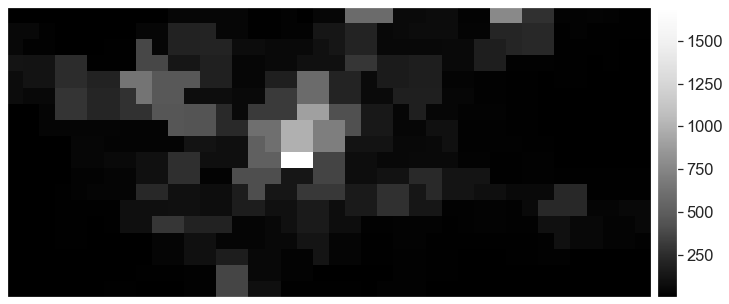

In [46]:
# Plot individual day worth of data for comparison
ep.plot_bands(march_01_2020_radiance, scale=False)

plt.show()

In [47]:
# Get min and max values for March 01
print(f"Min radiance: {march_01_2020_radiance.min()}")
print(f"Max radiance: {march_01_2020_radiance.max()}")

Min radiance: 4.0
Max radiance: 1697.0


#### Directly from Dictionary - Monthly Mean

In [48]:
# Get a month's worth of data (still in dictionary format)
march_2020_radiance_dict = radiance_sept_2019_apr_2020.get('2020').get('03')

In [49]:
# Get list of March 2020 arrays
march_2020_arrays = rd.flatten_data(march_2020_radiance_dict)

# Compute mean of a single month (provide list
#  of arrays to calculate_mean_radiance function)
march_2020_radiance_mean = rd.calculate_mean(march_2020_arrays)

In [50]:
# Get min and max values for March 2020 mean
print(f"Min radiance: {march_2020_radiance_mean.min()}")
print(f"Max radiance: {march_2020_radiance_mean.max()}")

Min radiance: 21.741935483870968
Max radiance: 430.03225806451616


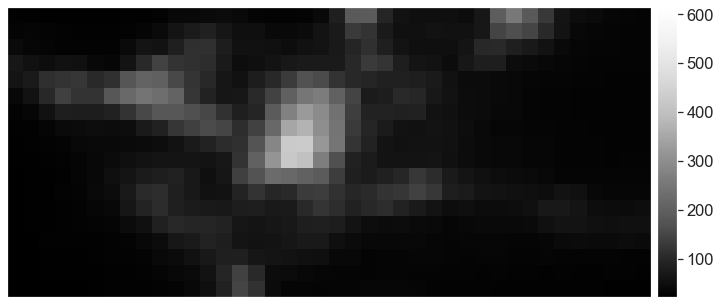

In [51]:
# Plot March 2020 mean
ep.plot_bands(march_2020_radiance_mean, scale=False, vmax=615)

In [52]:
# Get September 2019 values
september_2019_radiance_dict = radiance_sept_2019_apr_2020.get(
    '2019').get('09')

In [53]:
# Get all September arrays as list
sept_2019_array_list = rd.flatten_data(september_2019_radiance_dict)

# Compute mean of a single month (provide list
#  of arrays to calculate_mean_radiance function)
sept_2019_radiance_mean = rd.calculate_mean(sept_2019_array_list)

In [54]:
# Get min and max values for March 2020 mean
print(f"Min radiance: {sept_2019_radiance_mean.min()}")
print(f"Max radiance: {sept_2019_radiance_mean.max()}")

Min radiance: 21.565217391304348
Max radiance: 611.1739130434783


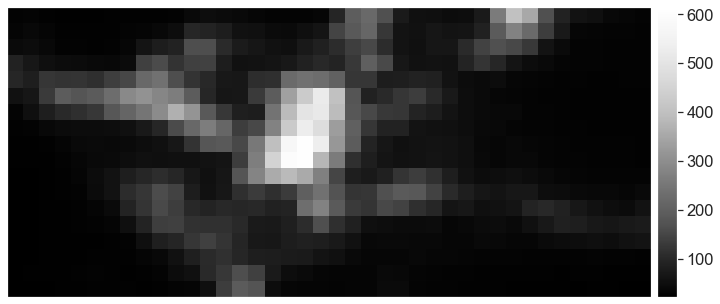

In [55]:
# Plot March 2020 mean
ep.plot_bands(sept_2019_radiance_mean, scale=False, vmax=615)

In [56]:
# Calculate difference from Sept 2019 to March 2020
diff_sept_2019_march_2020 = march_2020_radiance_mean - sept_2019_radiance_mean

In [57]:
# Get min and max values for difference in mean
print(f"Min difference (negative): {diff_sept_2019_march_2020.min()}")
print(f"Max difference (positive): {diff_sept_2019_march_2020.max()}")

Min difference (negative): -261.05469845722297
Max difference (positive): 28.802244039270676


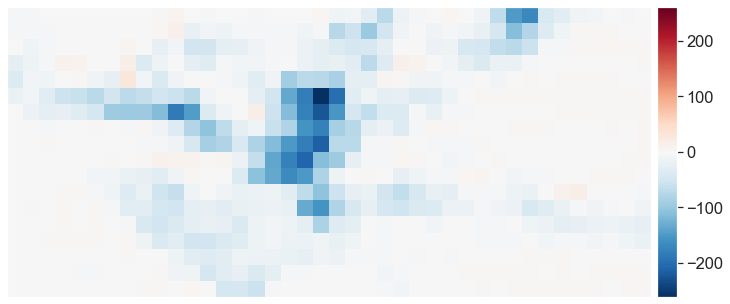

In [58]:
# Plot difference from Sept 2019 to March 2020
ep.plot_bands(
    diff_sept_2019_march_2020, 
    scale=False, 
    vmin=diff_sept_2019_march_2020.min(),
    vmax=-diff_sept_2019_march_2020.min(),
    cmap='RdBu_r')

plt.show()

### Full Month - Mean (Alternative Version)

In [59]:
# Get dates from Sept 01 - Sept 30
date_list = rd.create_date_list('2019-09-01', '2019-09-30')

In [60]:
# Get array for each date into list
sept_01_sep_30_arrays = rd.extract_data(
 radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [61]:
# Confirm length
len(sept_01_sep_30_arrays)

30

In [62]:
# Calculate mean
sept_01_sep_30_mean = rd.calculate_mean(sept_01_sep_30_arrays)

In [63]:
# Get min and max values for mean
print(f"Min: {sept_01_sep_30_mean.min()}")
print(f"Max: {sept_01_sep_30_mean.max()}")

Min: 21.565217391304348
Max: 611.1739130434783


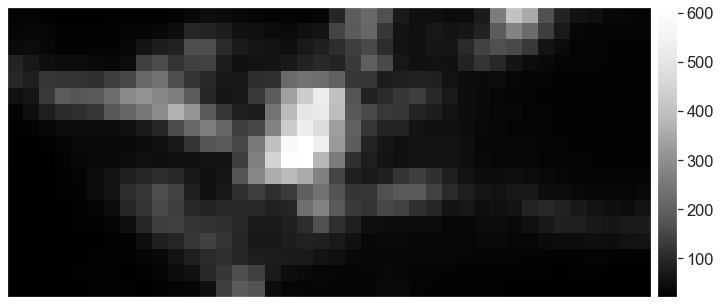

In [64]:
# Plot
ep.plot_bands(sept_01_sep_30_mean, scale=False, vmax=sept_01_sep_30_mean.max())

plt.show()

### Intra-Month Range - Mean

In [65]:
# Get dates from Sept 10 - Sept 20
date_list = rd.create_date_list('2019-09-10', '2019-09-20')

In [66]:
# Get array for each date into list
sept_10_sep_20_arrays = rd.extract_data(
 radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [67]:
# Confirm length
len(sept_10_sep_20_arrays)

11

In [68]:
# Calculate mean
sept_10_sep_20_mean = rd.calculate_mean(sept_10_sep_20_arrays)

In [69]:
# Get min and max values for mean
print(f"Min: {sept_10_sep_20_mean.min()}")
print(f"Max: {sept_10_sep_20_mean.max()}")

Min: 46.0
Max: 541.0


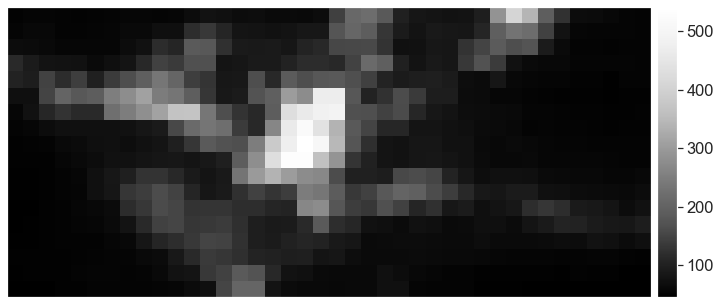

In [70]:
# Plot
ep.plot_bands(sept_10_sep_20_mean, scale=False, vmax=sept_10_sep_20_mean.max())

plt.show()

### Inter-Month Continuous Range - Mean

In [71]:
# Get dates from Sept 15 - Oct 15
date_list = rd.create_date_list('2019-09-15', '2019-10-15')

In [72]:
# Get array for each date into list
sept_15_oct_15_arrays = rd.extract_data(
    radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [73]:
# Confirm length
len(sept_15_oct_15_arrays)

31

In [74]:
# Calculate mean
sept_15_oct_15_mean = rd.calculate_mean(sept_15_oct_15_arrays)

In [75]:
# Get min and max values for mean
print(f"Min: {sept_15_oct_15_mean.min()}")
print(f"Max: {sept_15_oct_15_mean.max()}")

Min: 13.541666666666666
Max: 656.5833333333334


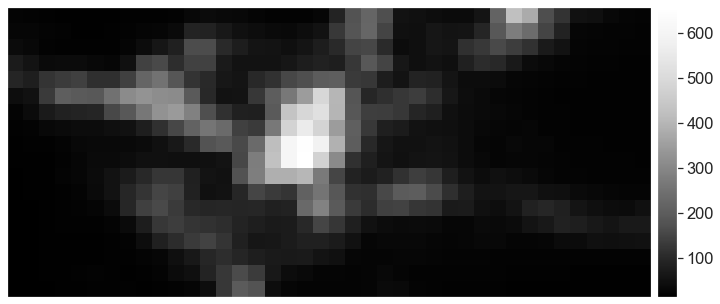

In [76]:
# Plot
ep.plot_bands(sept_15_oct_15_mean, scale=False, vmax=sept_15_oct_15_mean.max())

plt.show()

### Multiple Full Months - Mean

In [77]:
# Get dates from Dec 01 2019 - Jan 31 2020
date_list = rd.create_date_list('2019-12-01', '2020-01-31')

In [78]:
# Get array for each date into list
dec_2019_jan_2020_arrays = rd.extract_data(
    radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [79]:
# Confirm length
len(dec_2019_jan_2020_arrays)

62

In [80]:
# Calculate mean
dec_2019_jan_2020_mean = rd.calculate_mean(dec_2019_jan_2020_arrays)

In [81]:
# Get min and max values for mean
print(f"Min: {dec_2019_jan_2020_mean.min()}")
print(f"Max: {dec_2019_jan_2020_mean.max()}")

Min: 40.30508474576271
Max: 457.08474576271186


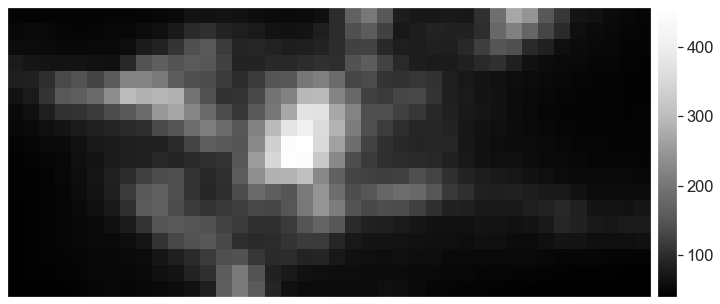

In [82]:
# Plot
ep.plot_bands(dec_2019_jan_2020_mean, scale=False, vmax=dec_2019_jan_2020_mean.max())

plt.show()

### Inter-Month (Every Specific Day) - Mean

Documentation for pandas *date_range*():

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets

Weekly:
* W-SUN - weekly frequency (Sundays). Same as ‘W’
* W-MON	- weekly frequency (Mondays)
* W-TUE - weekly frequency (Tuesdays)
* W-WED - weekly frequency (Wednesdays)
* W-THU - weekly frequency (Thursdays)
* W-FRI - weekly frequency (Fridays)
* W-SAT - weekly frequency (Saturdays)

#### Sundays

In [83]:
# Get Sundays from Sept 2019 - April 2020
date_list = rd.create_date_list('2019-09-01', '2020-04-30', date_frequency='W-SUN')

In [84]:
# Get array for each date into list
sept_2019_apr_2020_sundays_arrays = rd.extract_data(
 radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [85]:
# Confirm length
len(sept_2019_apr_2020_sundays_arrays)

35

In [86]:
# Calculate mean
sept_2019_apr_2020_sundays_mean = rd.calculate_mean(
    sept_2019_apr_2020_sundays_arrays)

In [87]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_sundays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_sundays_mean.max()}")

Min: 37.096774193548384
Max: 482.80645161290323


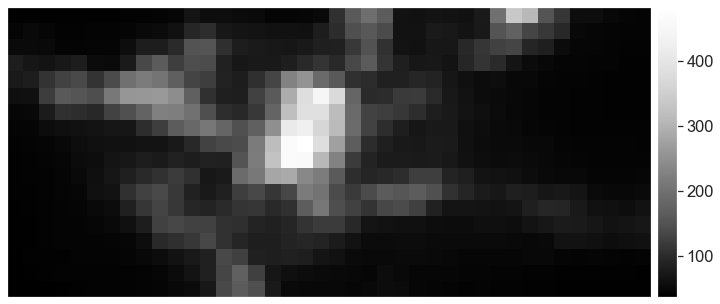

In [88]:
# Plot
ep.plot_bands(sept_2019_apr_2020_sundays_mean, scale=False,
              vmax=sept_2019_apr_2020_sundays_mean.max())

plt.show()

#### Mondays

In [89]:
# Get Mondays from Sept 2019 - April 2020
date_list = rd.create_date_list(
    '2019-09-01', '2020-04-30', date_frequency='W-MON')

In [90]:
# Get array for each date into list
sept_2019_apr_2020_mondays_arrays = rd.extract_data(
 radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [91]:
# Confirm length
len(sept_2019_apr_2020_mondays_arrays)

35

In [92]:
# Calculate mean
sept_2019_apr_2020_mondays_mean = rd.calculate_mean(
    sept_2019_apr_2020_mondays_arrays)

In [93]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_mondays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_mondays_mean.max()}")

Min: 33.111111111111114
Max: 448.77777777777777


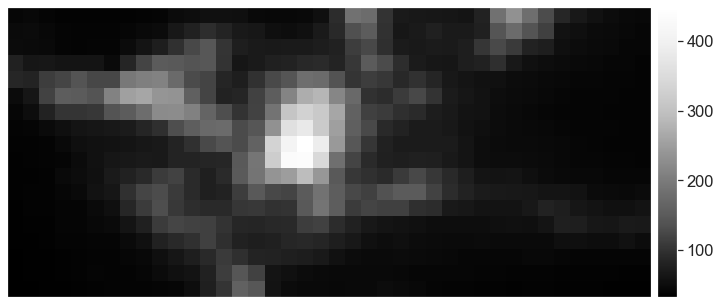

In [94]:
# Plot
ep.plot_bands(sept_2019_apr_2020_mondays_mean, scale=False,
              vmax=sept_2019_apr_2020_mondays_mean.max())

plt.show()

#### Business Days

In [95]:
# Get business days, March 2020
date_list = rd.create_date_list('2020-03-01', '2020-03-14', date_frequency='B')

In [96]:
# Get array for each date into list
march_2020_business_arrays = rd.extract_data(
 radiance=radiance_sept_2019_apr_2020, dates=date_list)

In [97]:
# Confirm length
len(march_2020_business_arrays)

10

In [98]:
# Calculate mean
march_2020_business_mean = rd.calculate_mean(march_2020_business_arrays)

In [99]:
# Get min and max values for mean
print(f"Min: {march_2020_business_mean.min()}")
print(f"Max: {march_2020_business_mean.max()}")

Min: 42.8
Max: 592.9


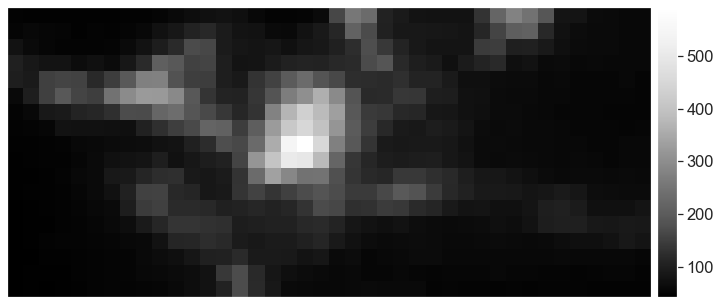

In [100]:
# Plot
ep.plot_bands(march_2020_business_mean, scale=False,
              vmax=march_2020_business_mean.max())

plt.show()

## Data Visualization

### Plot Cloud Free Mean Radiance Values for September 2019

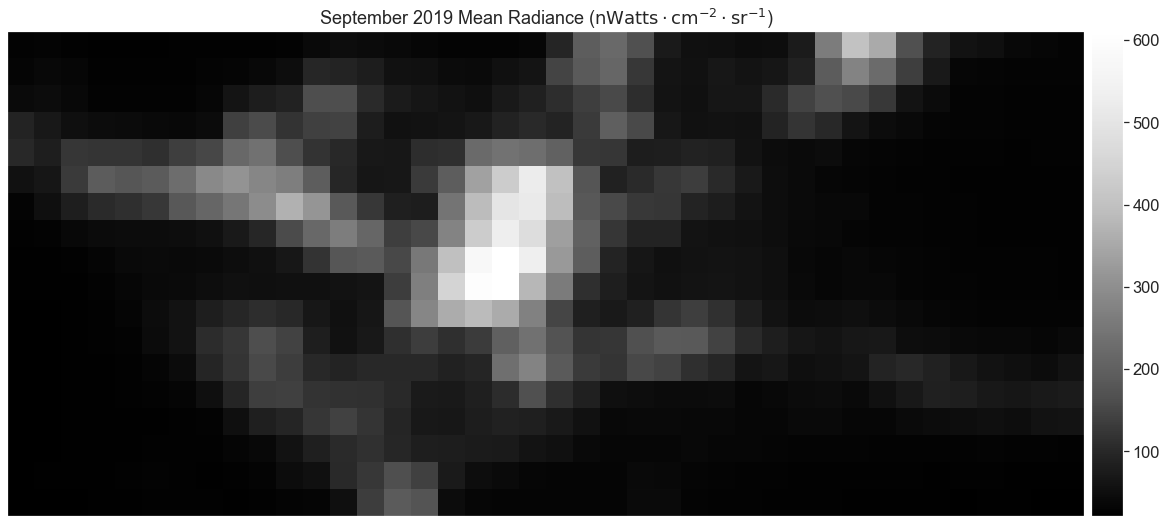

In [101]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot radiance values
ep.plot_bands(
    sept_2019_radiance_mean,
    title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax,
    vmax=sept_2019_radiance_mean.max())

# Plot lat/lon (centroids)
# psu_lat_lon_gdf.plot(ax=ax)

plt.show()

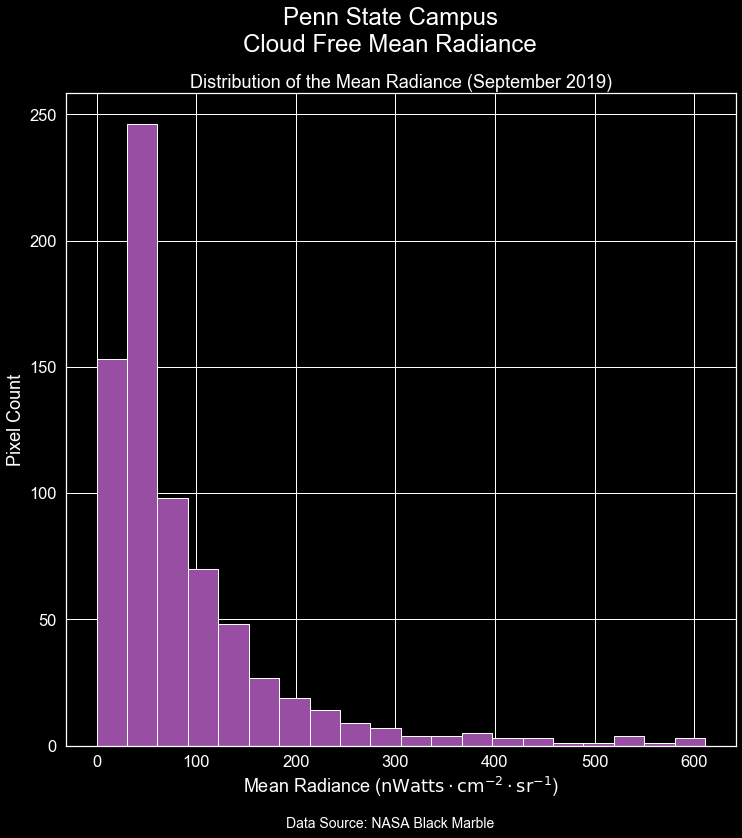

In [102]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        sept_2019_radiance_mean,
        hist_range=(0, sept_2019_radiance_mean.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (September 2019)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', 
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Mean Radiance Values for March 2020

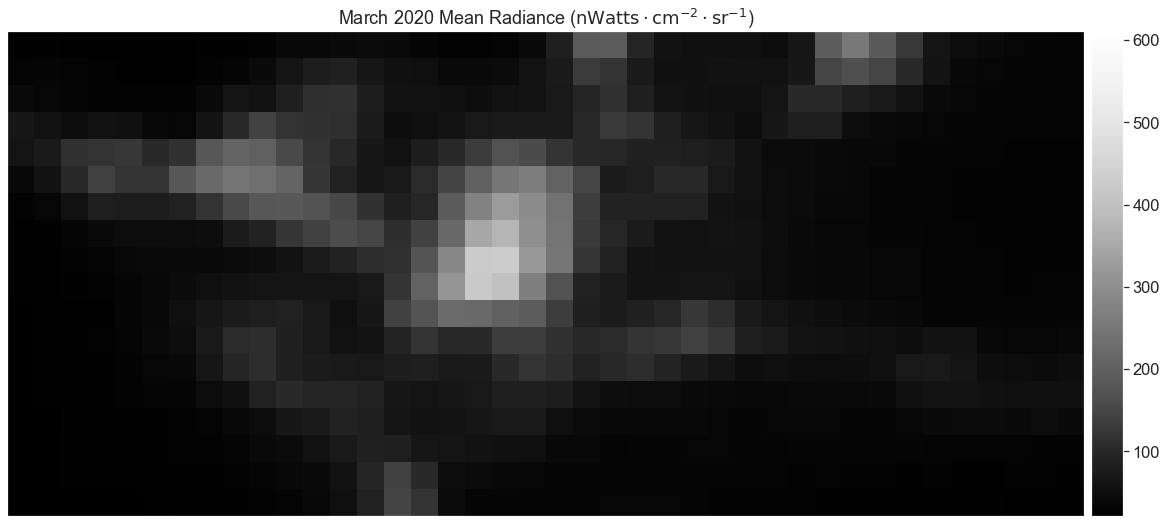

In [103]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(
    march_2020_radiance_mean,
    title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax, 
    vmax=sept_2019_radiance_mean.max())

plt.show()

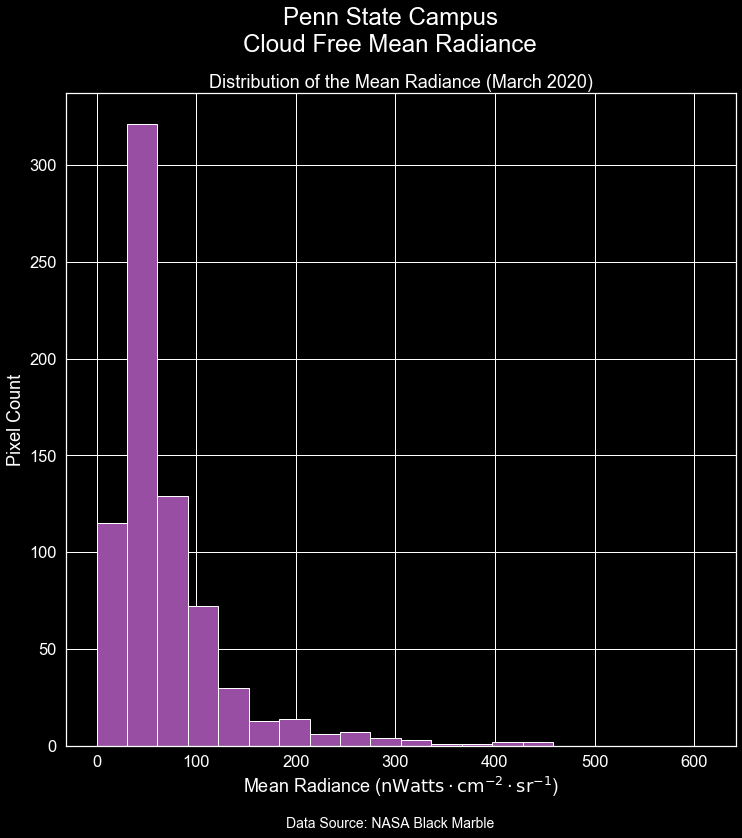

In [104]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        march_2020_radiance_mean,
        hist_range=(0, sept_2019_radiance_mean.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (March 2020)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)',
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Change in Mean Radiance Values from September 2019 to March 2020

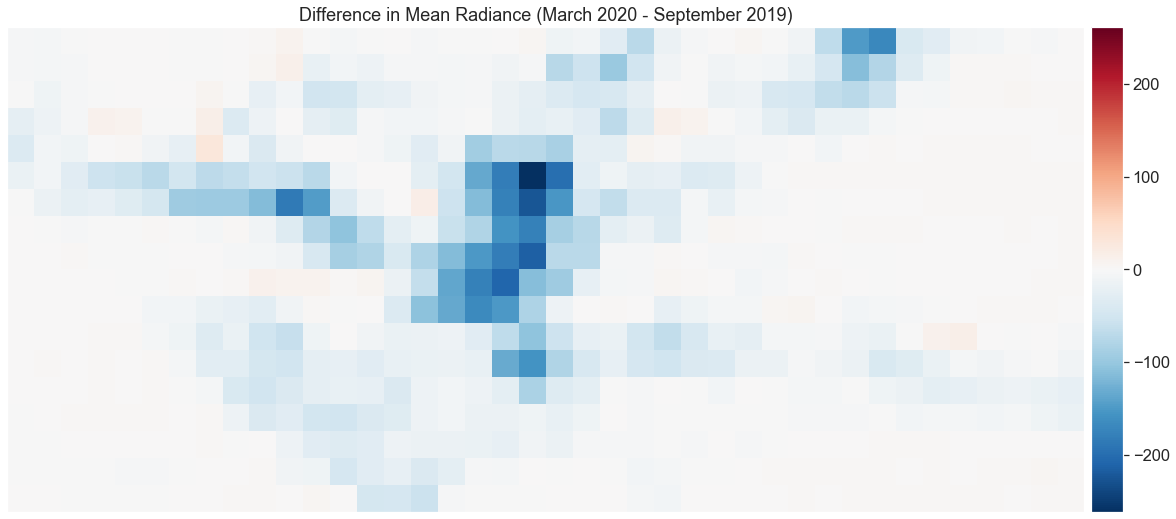

In [105]:
# Plot change in radiance values
ep.plot_bands(
    diff_sept_2019_march_2020, 
    title="Difference in Mean Radiance (March 2020 - September 2019)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff_sept_2019_march_2020.min(),
    vmax=-diff_sept_2019_march_2020.min(),
    extent=psu_extent)

plt.show()

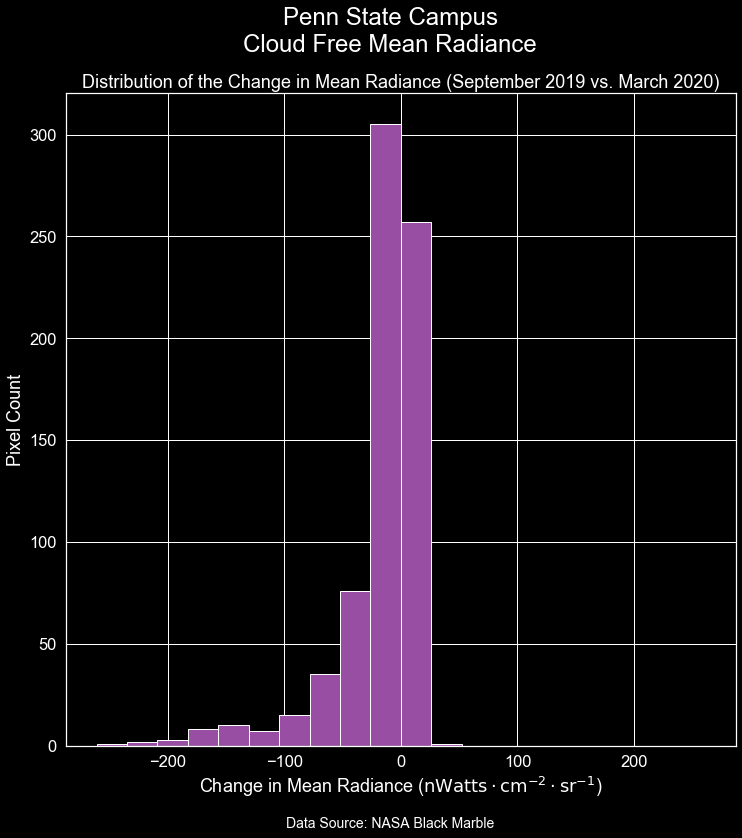

In [106]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

### Combined Plots

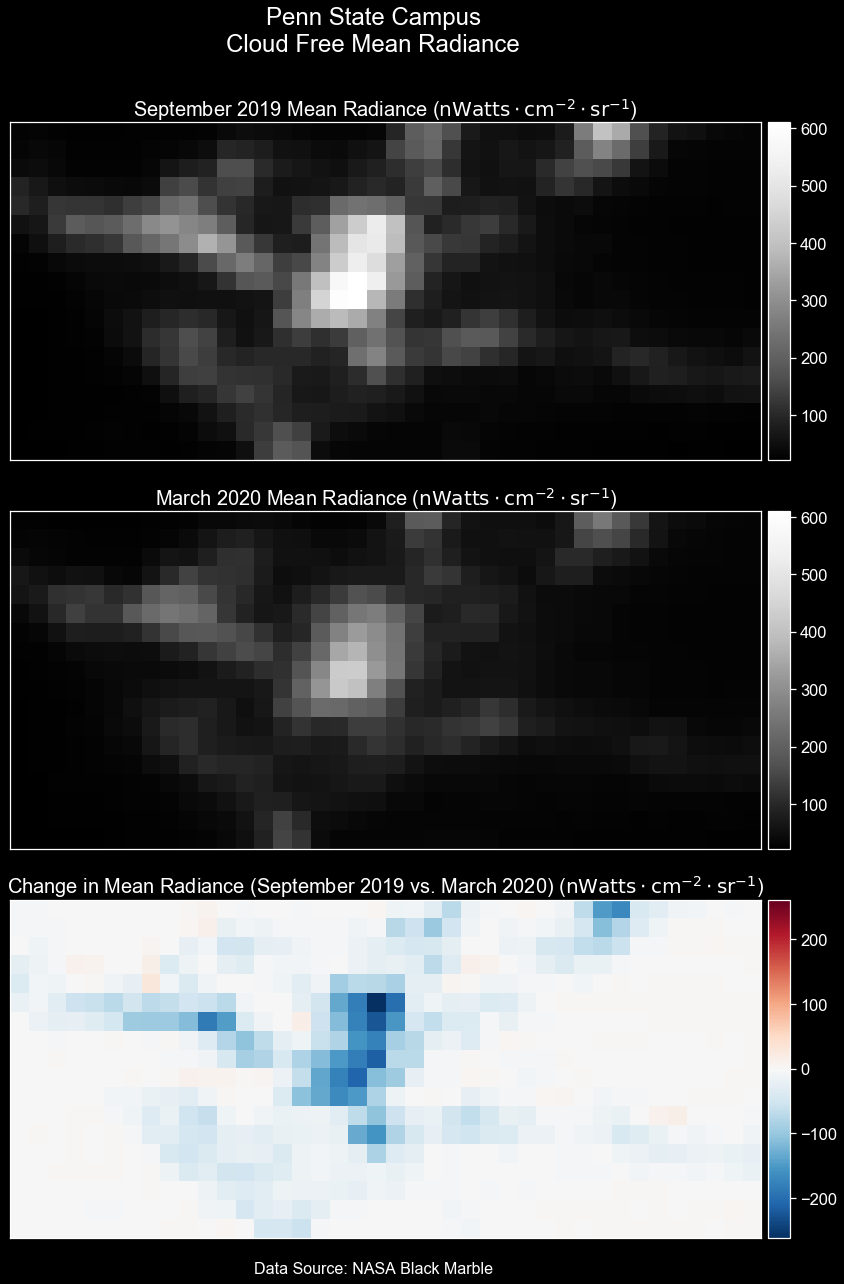

In [107]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        sept_2019_radiance_mean, title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_radiance_mean.max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        march_2020_radiance_mean, title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_radiance_mean.max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        diff_sept_2019_march_2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=diff_sept_2019_march_2020.min(),
        vmax=-diff_sept_2019_march_2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

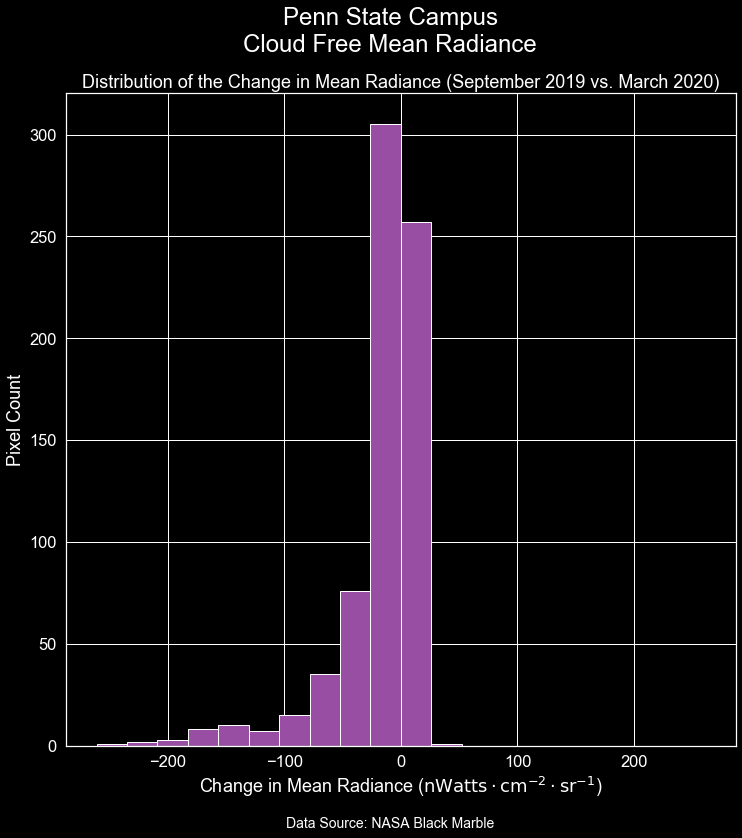

In [108]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        #         bins=40,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export

In [109]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept2019-march2020.tif")

In [110]:
# Define export transform
transform = from_origin(lon_min, lat_max, coord_spacing, coord_spacing)

# Define export metadata
psu_campus_metadata = {
    "driver": "GTiff",
    "dtype": diff_sept_2019_march_2020.dtype,
    "nodata": 0,
    "width": diff_sept_2019_march_2020.shape[1],
    "height": diff_sept_2019_march_2020.shape[0],
    "count": 1,
    "crs": psu_lat_lon_gdf.crs,  # +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
    "transform": transform
}

In [111]:
# Export September 2019 radiance
rd.export_array(
    array=sept_2019_radiance_mean,
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
rd.export_array(
    array=march_2020_radiance_mean,
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
rd.export_array(
    array=diff_sept_2019_march_2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)

Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\04-graphics-outputs\penn-state-campus-radiance-sept2019.tif
Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\04-graphics-outputs\penn-state-campus-radiance-march2020.tif
Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\04-graphics-outputs\penn-state-campus-radiance-difference-sept2019-march2020.tif
